<a href="https://colab.research.google.com/github/chenant2017/covid/blob/main/Copy_of_covid_(psi).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd ~/rmats_covid/covid2
!ls

/home/chenant/rmats_covid/covid2
combined2.csv			   go-basic.obo        psi
combined.csv			   heatmap.R	       __pycache__
csv				   mild_mod_to_sev     sashimi
gene2go				   moderate_severe     sig_exons_all
genes_ncbi_10090_proteincoding.py  moderate_severe_ns  sig_exons_ms
genes_ncbi_9606_proteincoding.py   moderate_severe_s   sig_exons_NEW


In [ ]:
!ls psi

A3SS.MATS.JCEC.txt		  JCEC.raw.input.MXE.txt
A3SS.MATS.JC.txt		  JCEC.raw.input.RI.txt
A5SS.MATS.JCEC.txt		  JCEC.raw.input.SE.txt
A5SS.MATS.JC.txt		  JC.raw.input.A3SS.txt
covid_psi.tar.gz		  JC.raw.input.A5SS.txt
fromGTF.A3SS.txt		  JC.raw.input.MXE.txt
fromGTF.A5SS.txt		  JC.raw.input.RI.txt
fromGTF.MXE.txt			  JC.raw.input.SE.txt
fromGTF.novelJunction.A3SS.txt	  metadata.txt
fromGTF.novelJunction.A5SS.txt	  metadata.txt:Zone.Identifier
fromGTF.novelJunction.MXE.txt	  MXE.MATS.JCEC.txt
fromGTF.novelJunction.RI.txt	  MXE.MATS.JC.txt
fromGTF.novelJunction.SE.txt	  out
fromGTF.novelSpliceSite.A3SS.txt  psi_ri.txt
fromGTF.novelSpliceSite.A5SS.txt  psi_se.txt
fromGTF.novelSpliceSite.MXE.txt   RI.MATS.JCEC.txt
fromGTF.novelSpliceSite.RI.txt	  RI.MATS.JC.txt
fromGTF.novelSpliceSite.SE.txt	  SE.MATS.JCEC.txt
fromGTF.RI.txt			  SE.MATS.JC.txt
fromGTF.SE.txt			  summary.txt
JCEC.raw.input.A3SS.txt		  tmp
JCEC.raw.input.A5SS.txt


In [ ]:
"""
class_exon class downloaded from
https://github.com/Xinglab/rmats-turbo-tutorial/tree/main/scripts

https://www.biostars.org/p/256949/

conda install build
cd rmats-turbo-tutorial/scripts
conda develop .  # this will install class_exon

TODO: get all PSI based on
https://github.com/Xinglab/rmats-turbo/issues/1
"""

from class_exon import get_exon_class
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:


def get_header(bams):
  runs = [[k.split(".")[0] for k in [j.split("/")[-1] for j in i.split(",")]] for i in bams.split("\n")]
  return runs[0] + runs[1]

def GetPSI(filename, min_count=15, qmin=0.05, qmax=0.95, header=None, bams=None, out=None, skip_filter=False):
  """ GetPSI in rMATS output.

  Added filters to select high-confidence alternative splicing events.
  The following criteria are recommended:
  • Read coverage: average RNA-seq read count ≥ 10 across all samples. (10/50)
  • PSI value: filter out events with average PSI value < 0.05 or > 0.95 in both sample groups.

  Args:
    filename: input file
    min_count: minimal average read count across all samples.
    qmin: min quantile to be aligned. Default 5%.
    qmax: max quantile to be aligned. Default 95%.
    skip_filter: whether to skip exon filter
  """

  exon, event_type = get_exon_class(filename)
  print(filename, "||||", event_type)
  n = 0
  id = [] #exon IDs
  psi = [] #all PSI values
  with open(filename, "r") as fin:
    fin.readline()
    for line in fin:
        x = exon(line)
        tpsi = np.array([i for i in (x.IncLevel1 + x.IncLevel2)]) #array of PSI of all samples. IMPORTANT: IncLevel means PSI
        if np.all(np.isnan(tpsi)):
          continue
        mean_psi = np.nanmean(tpsi)
        tpsi[np.isnan(tpsi)] = mean_psi #replace nan with mean
        if not skip_filter:
          if mean_psi < qmin or mean_psi > qmax or x.averageCount < min_count:
            continue
        id.append(x.uniqID)
        psi.append(tpsi)
  psi = pd.DataFrame(psi, index=id)
  if bams is not None:
    header = get_header(bams)
  if header:
    psi.columns = header
  if out:
    psi.to_csv(out, sep="\t")
  return  psi

# rMATS filtering

* Read coverage: average RNA-seq read count ≥ 15 in both sample groups.

* PSI value: filter out events with average PSI value < 0.05 or > 0.95 in both sample
groups.
* FDR: FDR ≤ 0.01.
* Between-group PSI value difference: |ΔPSI| ≥ 0.05.

In [ ]:
def GetExons(filename, psi=None, min_count=15, qmin=0.05, qmax=0.95, max_fdr=0.01, min_delta=0.05, out=None):
  """ GetPSI in rMATS output.

  Added filters to select high-confidence alternative splicing events.
  The following criteria are recommended:
  • Read coverage: average RNA-seq read count ≥ 10 in both sample groups.
  • PSI value: filter out events with average PSI value < 0.05 or > 0.95 in both sample groups.
  • FDR: FDR ≤ 0.01.
  • Between-group PSI value difference: |ΔPSI| ≥ 0.05.

  Args:
    filename: input file
    min_count: minimal average read count across all samples.
    qmin: min quantile to be aligned. Default 5%.
    qmax: max quantile to be aligned. Default 95%.
  """

  exon, event_type = get_exon_class(filename)
  print(filename, "||||", event_type)
  n = 0
  id = [] #exon ID
  rid = [] #row ID
  fdr = [] #false discovery rate (FDR)
  gene = [] #gene symbol
  delta = [] #Between-group PSI value difference
  with open(filename, "r") as fin:
    fin.readline()
    for line in fin:
        x = exon(line)
        if x.averageCount >= min_count: #read coverage filter
          tpsi = np.array([i for i in (x.IncLevel1 + x.IncLevel2)])
          if np.all(np.isnan(tpsi)):
            continue
          mean_psi = np.nanmean(tpsi)
          tpsi[np.isnan(tpsi)] = mean_psi
          if qmin <= mean_psi <= qmax:
              if x.FDR <= max_fdr and abs(x.IncLevelDifference) >= min_delta:
                id.append(x.uniqID)
                fdr.append(x.FDR)
                delta.append(x.IncLevelDifference)
                gene.append(x.geneSymbol)
                rid.append(x.ID)
  df = pd.DataFrame({'FDR':np.round(fdr, 5), 'IncLevelDifference':delta, 'Gene':gene, 'rowID':rid}, index=id)
  if psi is not None:
    df = psi.merge(right=df, right_index=True, left_index=True, how="inner") #add columns for additional attributes to the right
  if out:
    df.to_csv(out, sep="\t")
  return  df

In [ ]:
psi_col = """ERR6745775
ERR6745776
ERR6745777
ERR6745778
ERR6745779
ERR6745780
ERR6745781
ERR6745782
ERR6745783
ERR6745784
ERR6745785
ERR6745786
ERR6745787
ERR6745788
ERR6745789
ERR6745790
ERR6745791
ERR6745792
ERR6745793
ERR6745794
ERR6745795
ERR6745796
ERR6745797
ERR6745798
ERR6745799
ERR6745800
ERR6745801
ERR6745802
ERR6745803
ERR6745804
ERR6745805
ERR6745806
ERR6745807
ERR6745808
ERR6745809
ERR6745810
ERR6745811
ERR6745812
ERR6745813
ERR6745814
ERR6745815
ERR6745816
ERR6745817
ERR6745818
ERR6745819
ERR6745820
ERR6745821
ERR6745822
ERR6745823
ERR6745824
ERR6745825
ERR6745826
ERR6745827
ERR6745828
ERR6745829""".split("\n")

In [ ]:
types = ["SE", "RI", "MXE", "A3SS", "A5SS"]

for i in types:
  psi = GetPSI("psi/{}.MATS.JC.txt".format(i), header=psi_col, out="sig_exons_NEW/psi/{}.txt".format(i))
  GetExons("moderate_severe/{}.MATS.JC.txt".format(i), min_count=15, psi=psi, out="sig_exons_NEW/ms/{}.txt".format(i))
  GetExons("mild_mod_to_sev/{}.MATS.JC.txt".format(i), min_count=15, psi=psi, out="sig_exons_NEW/mms/{}.txt".format(i))

psi/SE.MATS.JC.txt |||| SE
moderate_severe/SE.MATS.JC.txt |||| SE
mild_mod_to_sev/SE.MATS.JC.txt |||| SE
psi/RI.MATS.JC.txt |||| RI
moderate_severe/RI.MATS.JC.txt |||| RI
mild_mod_to_sev/RI.MATS.JC.txt |||| RI
psi/MXE.MATS.JC.txt |||| MXE
moderate_severe/MXE.MATS.JC.txt |||| MXE
mild_mod_to_sev/MXE.MATS.JC.txt |||| MXE
psi/A3SS.MATS.JC.txt |||| A3SS
moderate_severe/A3SS.MATS.JC.txt |||| A3SS
mild_mod_to_sev/A3SS.MATS.JC.txt |||| A3SS
psi/A5SS.MATS.JC.txt |||| A5SS
moderate_severe/A5SS.MATS.JC.txt |||| A5SS
mild_mod_to_sev/A5SS.MATS.JC.txt |||| A5SS


In [ ]:
a.sort_values(by="FDR").head()

,Unnamed: 0,ERR6745775,ERR6745776,ERR6745777,ERR6745778,ERR6745779,ERR6745780,ERR6745781,ERR6745782,ERR6745783,...,ERR6745823,ERR6745824,ERR6745825,ERR6745826,ERR6745827,ERR6745828,ERR6745829,FDR,IncLevelDifference,Gene
19,chr6:150638079-150638125|+|150600017|150650727,0.000,0.000,0.000,0.000,0.099,0.234,0.179,0.000,0.434,...,0.133,0.000,0.094,0.000,0.000,0.000,0.078,0.00001,0.160,PLEKHG1
110,chr12:106959269-106959385|+|106957149|106967110,0.049,0.075,0.303,0.000,0.000,0.083,0.000,0.056,0.172,...,0.050,0.059,0.229,0.083,0.000,0.000,0.000,0.00001,0.080,TMEM263
18,chr15:33088798-33088974|-|33065074|33153047,1.000,0.776,0.840,1.000,0.733,1.000,0.967,0.556,0.960,...,1.000,1.000,1.000,0.500,0.938,0.724,0.750,0.00001,0.054,FMN1
56,chr14:100374135-100374244|-|100369258|100376259,0.000,0.143,0.199,0.000,0.019,0.000,0.232,0.000,0.323,...,0.000,0.272,0.000,0.267,0.000,0.012,0.000,0.00001,0.161,WARS
73,chr7:66476258-66476327|-|66467719|66479008,1.000,1.000,0.593,0.646,1.000,0.935,0.813,1.000,0.883,...,0.906,0.911,0.774,0.755,0.601,0.774,0.785,0.00001,0.124,LINC00174


In [ ]:
!wc sig_exons_all/mms/*

    21   1238   8042 sig_exons_all/mms/A3SS.txt
    15    884   5885 sig_exons_all/mms/A5SS.txt
    99   5840  39605 sig_exons_all/mms/MXE.txt
    77   4542  29868 sig_exons_all/mms/RI.txt
   144   8495  53687 sig_exons_all/mms/SE.txt
   356  20999 137087 total


In [ ]:
!ls sig_exons_NEW/psi

A3SS.txt  A5SS.txt  MXE.txt  RI.txt  SE.txt


In [ ]:
for t in ["SE", "RI", "MXE", "A3SS", "A5SS"]:
  df = pd.read_csv("sig_exons_NEW/mms/" + t + ".txt", sep='\t')
  df2 = pd.read_csv("sig_exons_NEW/ms/" + t + ".txt", sep='\t')
  count = 0
  for asdf in df['Unnamed: 0']:
    if asdf in df2['Unnamed: 0']:
      count += 1
  print(t, count)

SE 0
RI 0
MXE 0
A3SS 0
A5SS 0


In [ ]:
df = pd.read_csv("sig_exons_NEW/psi/" + "A3SS" + ".txt", sep='\t')
df['Unnamed: 0'][0]

'chr21:45505357-45505431|+|45505834|45505837'

In [ ]:
def GetPSICounts(filename):
  exon, event_type = get_exon_class(filename)
  print(filename, "||||", event_type)
  n = 0
  id = []
  psi = []
  count = []
  with open(filename, "r") as fin:
    fin.readline()
    for line in fin:
        x = exon(line)
        tpsi = np.array([i for i in (x.IncLevel1 + x.IncLevel2)])
        if np.all(np.isnan(tpsi)):
          continue
        psi.append(np.nanmean(tpsi))
        id.append(x.uniqID)
        count.append(np.mean([
            (i + j) for i, j in zip(x.IJC_SAMPLE_1 + x.IJC_SAMPLE_2,
                                    x.SJC_SAMPLE_1 + x.SJC_SAMPLE_2)]))
        # TODO: counts distribution
  df = pd.DataFrame(zip(psi, count), index=id)
  return df

In [ ]:
psi_se = GetPSICounts("psi/SE.MATS.JC.txt")
psi_se.columns = ['PSI', 'Read Count']

psi/SE.MATS.JC.txt |||| SE


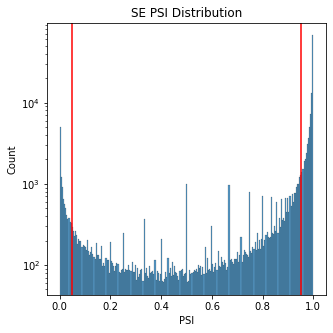

In [ ]:
h = sns.histplot(psi_se['PSI'])
h.axvline(0.05, color='red')
h.axvline(0.95, color='red')
h.set(title="SE PSI Distribution")
h.set_yscale("log")
h.figure.set_size_inches(5, 5)

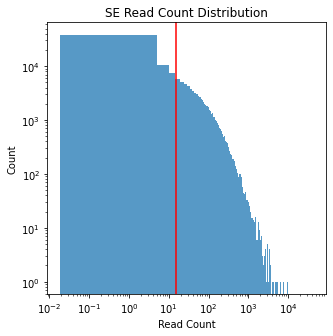

In [ ]:
h = sns.histplot(psi_se['Read Count'])
h.set(title="SE Read Count Distribution")
h.axvline(15, color="red")
h.set_xscale("log")
h.set_yscale("log")
h.figure.set_size_inches(5, 5)